In [1]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Надёжно определяем корень проекта
cwd = Path.cwd()
PROJECT_ROOT = cwd.parent if cwd.name == "notebooks" else cwd

DATA_PATH = PROJECT_ROOT / "data" / "Real_Estate_Tel_Aviv_20_years.csv"
MODELS_DIR = PROJECT_ROOT / "models"
PICS_DIR = PROJECT_ROOT / "pics"

MODELS_DIR.mkdir(exist_ok=True)
PICS_DIR.mkdir(exist_ok=True)

DATA_PATH, MODELS_DIR, PICS_DIR


(PosixPath('/Users/nikitamarshchonok/Desktop/end-to-end ML project/data/Real_Estate_Tel_Aviv_20_years.csv'),
 PosixPath('/Users/nikitamarshchonok/Desktop/end-to-end ML project/models'),
 PosixPath('/Users/nikitamarshchonok/Desktop/end-to-end ML project/pics'))

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head(3))

# --- авто-поиск target колонки (цены) ---
cols_lower = {c: str(c).lower() for c in df.columns}

# кандидаты по ключевым словам
keywords = ["price", "deal", "amount", "value", "nis", "ils", "₪", "sale", "sum", "total"]
candidates = [c for c, cl in cols_lower.items() if any(k in cl for k in keywords)]

print("\nCandidates by keywords:")
print(candidates)

target_col = None
# приоритет: ровно "price", потом содержащие "price"
for c in df.columns:
    if cols_lower[c] == "price":
        target_col = c
        break
if target_col is None:
    for c in df.columns:
        if "price" in cols_lower[c]:
            target_col = c
            break

# если не нашли — покажем топ числовых колонок (чтобы выбрать руками)
if target_col is None:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print("\nNo explicit price found. Numeric columns:")
    print(num_cols[:40])
    print("\n👉 If you see the price column above, set it manually like:")
    print("target_col = 'YOUR_COLUMN_NAME'")
else:
    print("\n✅ Selected target_col:", target_col)

# базовая чистка цены (если нашли)
if target_col is not None:
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
    before = len(df)
    df = df[df[target_col].notna() & (df[target_col] > 0)].copy()
    print(f"Target cleaned: {before} -> {len(df)} rows")


Shape: (5901, 40)


,subLot,lot,bloc,transactionDate,street,houseNumber,apartmentNumber,price,grossArea,netArea,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,5,814,6628,01/12/2020,1,9,5.0,4636021,118.0,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,814,6628,29/10/2020,1,5,5.0,4559044,118.0,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48,640,6628,15/06/2020,1,48,48.0,7350000,196.0,196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Candidates by keywords:
['price']

✅ Selected target_col: price
Target cleaned: 5901 -> 5896 rows


In [3]:
import json

v2_feats_path = MODELS_DIR / "tel_aviv_feature_cols_v2.json"
print("v2 feats json:", v2_feats_path)

with open(v2_feats_path, "r", encoding="utf-8") as f:
    feat_cols = json.load(f)

print("Features in v2:", len(feat_cols))
print("First 10 feats:", feat_cols[:10])

missing = [c for c in feat_cols if c not in df.columns]
extra_in_df = [c for c in df.columns if c not in feat_cols]

print("\nMissing v2 features in dataset:", missing)
print("Example columns in df:", list(df.columns)[:25])

# Подготовка X/y (как в v2)
if len(missing) == 0:
    X = df[feat_cols].copy()
    y_raw = df["price"].values
    y = np.log1p(y_raw)

    # safety
    X = X.replace([np.inf, -np.inf], np.nan)
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    print("\n✅ X shape:", X.shape)
    print("✅ y shape:", y.shape)
else:
    print("\n❗️Надо строить v2-фичи через build_tel_aviv_v2_features (в следующем шаге дам код).")


v2 feats json: /Users/nikitamarshchonok/Desktop/end-to-end ML project/models/tel_aviv_feature_cols_v2.json
Features in v2: 16
First 10 feats: ['netArea', 'grossArea', 'rooms', 'floor', 'floors', 'apartmentsInBuilding', 'parking', 'storage', 'roof', 'yard']

Missing v2 features in dataset: ['tx_year', 'tx_month', 'tx_quarter', 'building_age_at_tx', 'floor_ratio']
Example columns in df: ['subLot', 'lot', 'bloc', 'transactionDate', 'street', 'houseNumber', 'apartmentNumber', 'price', 'grossArea', 'netArea', 'rooms', 'ppsm', 'ppr', 'floor', 'floors', 'apartmentsInBuilding', 'parking', 'storage', 'roof', 'yard', 'constructionYear', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24']

❗️Надо строить v2-фичи через build_tel_aviv_v2_features (в следующем шаге дам код).


In [4]:
import numpy as np
import pandas as pd

df_feat = df.copy()

# 1) transactionDate -> datetime
df_feat["transactionDate"] = pd.to_datetime(df_feat["transactionDate"], errors="coerce")

# 2) Числовые поля (на всякий)
for col in ["constructionYear", "floor", "floors"]:
    if col in df_feat.columns:
        df_feat[col] = pd.to_numeric(df_feat[col], errors="coerce")

# 3) Derived time features
df_feat["tx_year"] = df_feat["transactionDate"].dt.year
df_feat["tx_month"] = df_feat["transactionDate"].dt.month
df_feat["tx_quarter"] = df_feat["transactionDate"].dt.quarter

# 4) building age at tx
df_feat["building_age_at_tx"] = df_feat["tx_year"] - df_feat["constructionYear"]
# защита от мусора
df_feat.loc[df_feat["building_age_at_tx"] < 0, "building_age_at_tx"] = np.nan
df_feat.loc[df_feat["building_age_at_tx"] > 200, "building_age_at_tx"] = np.nan

# 5) floor_ratio
den = df_feat["floors"].replace({0: np.nan})
df_feat["floor_ratio"] = df_feat["floor"] / den
df_feat.loc[(df_feat["floor_ratio"] < 0) | (df_feat["floor_ratio"] > 1.5), "floor_ratio"] = np.nan

# 6) Проверим, что теперь все v2 фичи есть
missing_after = [c for c in feat_cols if c not in df_feat.columns]
print("Missing after build:", missing_after)

# 7) Собираем X/y
X = df_feat[feat_cols].copy()
y_raw = df_feat["price"].values
y = np.log1p(y_raw)

# 8) Быстрый "медианный" импьютер для оценки (на случай, если pkl не pipeline)
X_num = X.apply(pd.to_numeric, errors="coerce")
nan_counts = X_num.isna().sum().sort_values(ascending=False)
print("\nNaNs per feature (top):")
print(nan_counts.head(10))

X_ready = X_num.copy()
for c in X_ready.columns:
    med = X_ready[c].median()
    if pd.isna(med):
        med = 0
    X_ready[c] = X_ready[c].fillna(med)

print("\n✅ X_ready shape:", X_ready.shape)
print("✅ y shape:", y.shape)


Missing after build: []

NaNs per feature (top):
building_age_at_tx      4155
tx_year                 3959
tx_month                3959
tx_quarter              3959
storage                 2574
yard                    2541
roof                    2514
parking                 2352
apartmentsInBuilding    1585
grossArea               1243
dtype: int64

✅ X_ready shape: (5896, 16)
✅ y shape: (5896,)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np

# Берём "сырой" X с NaN (модель v2 часто = pipeline и сама умеет имpute)
X_raw = df_feat[feat_cols].copy()
X_raw = X_raw.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# y уже есть (log1p), y_raw тоже есть (price)
# На всякий случай:
y_raw = df_feat["price"].values
y = np.log1p(y_raw)

X_train_raw, X_test_raw, y_train, y_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, y, y_raw, test_size=0.2, random_state=RANDOM_STATE
)

v2_model_path = MODELS_DIR / "tel_aviv_real_estate_model_v2.pkl"
print("Loading:", v2_model_path)

v2_model = joblib.load(v2_model_path)

# Пытаемся предсказать через v2 pipeline на X_raw.
# Если вдруг модель НЕ pipeline и упадет из-за NaN — используем X_ready (уже без NaN).
try:
    pred_log_v2 = v2_model.predict(X_test_raw)
    used = "X_test_raw (with NaNs)"
except Exception as e:
    print("\n⚠️ v2_model failed on X_test_raw, fallback to X_ready.")
    print("Error:", repr(e))
    # делаем такой же split для X_ready
    X_train_ready, X_test_ready = train_test_split(
        X_ready, test_size=0.2, random_state=RANDOM_STATE
    )
    pred_log_v2 = v2_model.predict(X_test_ready)
    used = "X_test_ready (imputed)"

pred_v2 = np.expm1(pred_log_v2)

mae_v2 = mean_absolute_error(y_raw_test, pred_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_raw_test, pred_v2))
r2_v2 = r2_score(y_raw_test, pred_v2)

print("\n✅ Baseline v2 metrics")
print("Used input:", used)
print(f"MAE : {mae_v2:,.0f} NIS")
print(f"RMSE: {rmse_v2:,.0f} NIS")
print(f"R2  : {r2_v2:.4f}")


Loading: /Users/nikitamarshchonok/Desktop/end-to-end ML project/models/tel_aviv_real_estate_model_v2.pkl

✅ Baseline v2 metrics
Used input: X_test_raw (with NaNs)
MAE : 597,842 NIS
RMSE: 1,153,491 NIS
R2  : 0.7422


In [7]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# кастомный scorer: y_true и y_pred в log1p, переводим в NIS
def mae_nis_from_log(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

mae_scorer = make_scorer(mae_nis_from_log, greater_is_better=False)

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_dist = {
    "rf__n_estimators": [400, 700, 1000, 1400],
    "rf__max_depth": [None, 12, 18, 25, 35, 50],
    "rf__min_samples_split": [2, 5, 10, 15],
    "rf__min_samples_leaf": [1, 2, 4, 8],
    "rf__max_features": ["sqrt", "log2", 0.5, 0.7],
    "rf__bootstrap": [True, False],
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,          # если хочешь сильнее — 40; если греется — 15
    scoring=mae_scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

search.fit(X_train_raw, y_train)

best_model = search.best_estimator_
print("\n✅ Best params:", search.best_params_)
print("✅ Best CV MAE (NIS):", -search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=400; total time=   0.9s
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=400; total time=   1.1s
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=400; total time=   1.1s
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=400; total time=   1.2s
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=400; total time=   1.2s
[CV] END rf__bootstrap=True, rf__max_depth=50, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=15, rf__n_estimat

/Users/nikitamarshchonok/Desktop/end-to-end ML project/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__bootstrap=False, rf__max_depth=50, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=700; total time=   3.7s
[CV] END rf__bootstrap=True, rf__max_depth=50, rf__max_features=0.7, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=1400; total time=   9.8s
[CV] END rf__bootstrap=False, rf__max_depth=50, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=700; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=50, rf__max_features=0.7, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=1400; total time=   9.7s
[CV] END rf__bootstrap=True, rf__max_depth=50, rf__max_features=0.7, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=1400; total time=   9.0s
[CV] END rf__bootstrap=True, rf__max_depth=50, rf__max_features=0.7, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=1400; total time=   9.5s
[CV] END rf__bootstrap=True, rf__m

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# предсказание (модель выдаёт log1p(price))
pred_log_v3 = best_model.predict(X_test_raw)
pred_v3 = np.expm1(pred_log_v3)

mae_v3 = mean_absolute_error(y_raw_test, pred_v3)
rmse_v3 = np.sqrt(mean_squared_error(y_raw_test, pred_v3))
r2_v3 = r2_score(y_raw_test, pred_v3)

print("\n✅ v3 TEST metrics")
print(f"MAE : {mae_v3:,.0f} NIS")
print(f"RMSE: {rmse_v3:,.0f} NIS")
print(f"R2  : {r2_v3:.4f}")

print("\n📌 Comparison vs v2 (holdout)")
print(f"v2 MAE : {mae_v2:,.0f} NIS")
print(f"ΔMAE   : {(mae_v2 - mae_v3):,.0f} NIS  (positive = v3 better)")



✅ v3 TEST metrics
MAE : 707,390 NIS
RMSE: 1,480,837 NIS
R2  : 0.5751

📌 Comparison vs v2 (holdout)
v2 MAE : 597,842 NIS
ΔMAE   : -109,548 NIS  (positive = v3 better)


In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

def mae_nis_from_log(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))

mae_scorer = make_scorer(mae_nis_from_log, greater_is_better=False)

pipe2 = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_dist2 = {
    "rf__n_estimators": [600, 900, 1200, 1600],
    "rf__max_depth": [None, 15, 25, 40],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4, 8],
    "rf__max_features": ["sqrt", 0.5, 0.7, 1.0],
    "rf__bootstrap": [True],  # фиксируем True (часто стабильнее)
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search2 = RandomizedSearchCV(
    estimator=pipe2,
    param_distributions=param_dist2,
    n_iter=25,          # если захочешь сильнее — 40
    scoring=mae_scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

search2.fit(X_train_raw, y_train)

best_model_31 = search2.best_estimator_
print("\n✅ Best params v3.1:", search2.best_params_)
print("✅ Best CV MAE v3.1 (NIS):", -search2.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END rf__bootstrap=True, rf__max_depth=40, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=10, rf__n_estimators=600; total time=   3.0s
[CV] END rf__bootstrap=True, rf__max_depth=40, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=10, rf__n_estimators=600; total time=   3.0s
[CV] END rf__bootstrap=True, rf__max_depth=40, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=10, rf__n_estimators=600; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=40, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=10, rf__n_estimators=600; total time=   3.4s
[CV] END rf__bootstrap=True, rf__max_depth=40, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=10, rf__n_estimators=600; total time=   3.5s
[CV] END rf__bootstrap=True, rf__max_depth=15, rf__max_features=0.7, rf__min_samples_leaf=8, rf__min_samples_split=2, rf__n_estimators=600

/Users/nikitamarshchonok/Desktop/end-to-end ML project/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=5, rf__n_estimators=900; total time=   5.3s
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=5, rf__n_estimators=900; total time=   5.3s
[CV] END rf__bootstrap=True, rf__max_depth=25, rf__max_features=0.5, rf__min_samples_leaf=8, rf__min_samples_split=5, rf__n_estimators=900; total time=   5.6s
[CV] END rf__bootstrap=True, rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=600; total time=   2.2s
[CV] END rf__bootstrap=True, rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=600; total time=   2.0s
[CV] END rf__bootstrap=True, rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=600; total time=   2.5s
[CV] END rf__bootstrap=True, rf__max_depth=

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

pred_log_31 = best_model_31.predict(X_test_raw)
pred_31 = np.expm1(pred_log_31)

mae_31 = mean_absolute_error(y_raw_test, pred_31)
rmse_31 = np.sqrt(mean_squared_error(y_raw_test, pred_31))
r2_31 = r2_score(y_raw_test, pred_31)

print("\n✅ v3.1 TEST metrics")
print(f"MAE : {mae_31:,.0f} NIS")
print(f"RMSE: {rmse_31:,.0f} NIS")
print(f"R2  : {r2_31:.4f}")

print("\n📌 Comparison vs v2 (holdout)")
print(f"v2 MAE : {mae_v2:,.0f} NIS")
print(f"ΔMAE   : {(mae_v2 - mae_31):,.0f} NIS  (positive = v3.1 better)")



✅ v3.1 TEST metrics
MAE : 712,072 NIS
RMSE: 1,473,875 NIS
R2  : 0.5791

📌 Comparison vs v2 (holdout)
v2 MAE : 597,842 NIS
ΔMAE   : -114,230 NIS  (positive = v3.1 better)


In [11]:
from sklearn.base import clone
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("v2_model type:", type(v2_model))
print(v2_model)

# Если это Pipeline — покажем шаги
if hasattr(v2_model, "named_steps"):
    print("\nPipeline steps:", list(v2_model.named_steps.keys()))
    # если есть rf — покажем параметры
    if "rf" in v2_model.named_steps:
        print("\nRF params in v2_model:")
        print(v2_model.named_steps["rf"].get_params())

# Клонируем модель (без утечки) и обучаем только на train
v2_fair = clone(v2_model)
v2_fair.fit(X_train_raw, y_train)

pred_log_v2_fair = v2_fair.predict(X_test_raw)
pred_v2_fair = np.expm1(pred_log_v2_fair)

mae_v2_fair = mean_absolute_error(y_raw_test, pred_v2_fair)
rmse_v2_fair = np.sqrt(mean_squared_error(y_raw_test, pred_v2_fair))
r2_v2_fair = r2_score(y_raw_test, pred_v2_fair)

print("\n✅ FAIR v2 metrics (trained only on train)")
print(f"MAE : {mae_v2_fair:,.0f} NIS")
print(f"RMSE: {rmse_v2_fair:,.0f} NIS")
print(f"R2  : {r2_v2_fair:.4f}")

print("\n📌 Compare FAIR v2 vs v3.1")
print(f"v3.1 MAE: {mae_31:,.0f} NIS")
print(f"ΔMAE    : {(mae_v2_fair - mae_31):,.0f} NIS (positive = v3.1 better)")


v2_model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(n_estimators=500, n_jobs=-1,
                                       random_state=42))])

Pipeline steps: ['imputer', 'model']

✅ FAIR v2 metrics (trained only on train)
MAE : 716,106 NIS
RMSE: 1,470,703 NIS
R2  : 0.5809

📌 Compare FAIR v2 vs v3.1
v3.1 MAE: 712,072 NIS
ΔMAE    : 4,034 NIS (positive = v3.1 better)


In [12]:
import json
import joblib
from datetime import datetime

model_v3_path = MODELS_DIR / "tel_aviv_real_estate_model_v3.pkl"
feats_v3_path = MODELS_DIR / "tel_aviv_feature_cols_v3.json"
metrics_v3_path = MODELS_DIR / "tel_aviv_metrics_v3.json"

# сохраняем модель (это best_model_31)
joblib.dump(best_model_31, model_v3_path)

with open(feats_v3_path, "w", encoding="utf-8") as f:
    json.dump(feat_cols, f, ensure_ascii=False, indent=2)

metrics = {
    "version": "v3",
    "model": "RandomForestRegressor tuned + SimpleImputer(median, add_indicator=True) + log1p(price)",
    "date_trained": datetime.now().strftime("%Y-%m-%d %H:%M"),
    "test_mae_nis": float(mae_31),
    "test_rmse_nis": float(rmse_31),
    "test_r2": float(r2_31),
    "fair_v2_mae_nis": float(mae_v2_fair),
    "delta_mae_vs_fair_v2_nis": float(mae_v2_fair - mae_31),
    "best_params": search2.best_params_,
    "features_count": len(feat_cols),
    "features": feat_cols
}

with open(metrics_v3_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("✅ Saved:", model_v3_path)
print("✅ Saved:", feats_v3_path)
print("✅ Saved:", metrics_v3_path)


✅ Saved: /Users/nikitamarshchonok/Desktop/end-to-end ML project/models/tel_aviv_real_estate_model_v3.pkl
✅ Saved: /Users/nikitamarshchonok/Desktop/end-to-end ML project/models/tel_aviv_feature_cols_v3.json
✅ Saved: /Users/nikitamarshchonok/Desktop/end-to-end ML project/models/tel_aviv_metrics_v3.json


Importances: 31 Feature names: 31


,feature,importance
1,grossArea,0.256821
10,constructionYear,0.208689
0,netArea,0.131003
2,rooms,0.097582
4,floors,0.053444
5,apartmentsInBuilding,0.047584
15,floor_ratio,0.041897
11,tx_year,0.030684
3,floor,0.029581
12,tx_month,0.018320


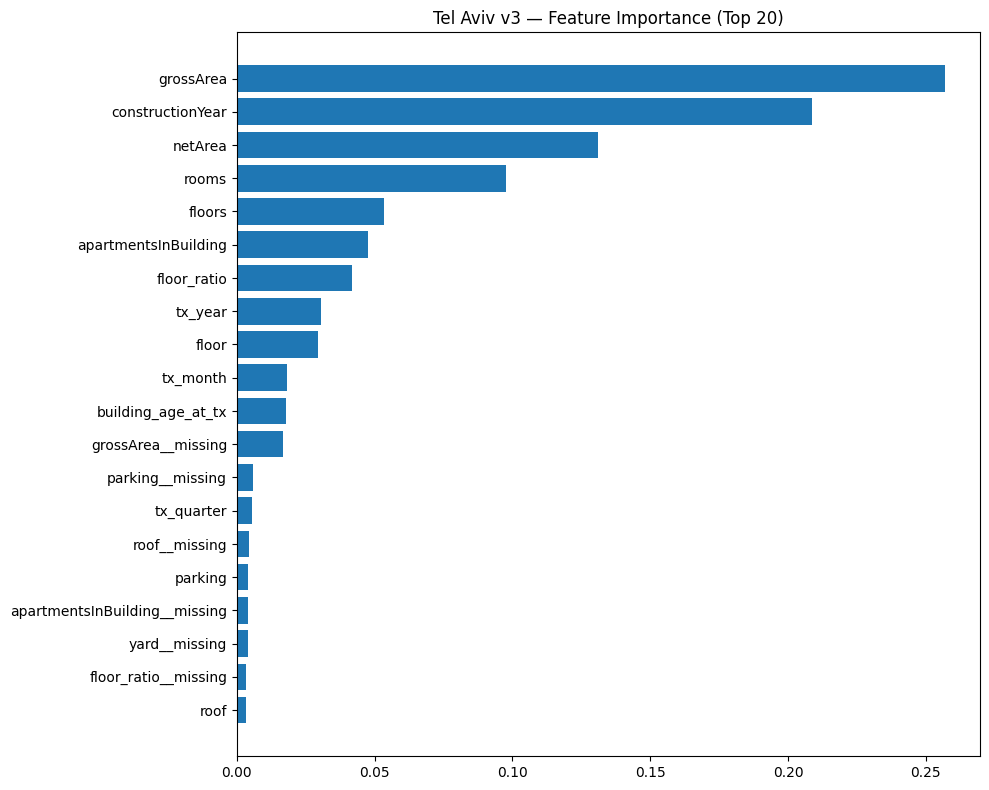

✅ Saved plot: /Users/nikitamarshchonok/Desktop/end-to-end ML project/pics/tel_aviv_v3_feature_importance.png


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# достаём имена фичей после имьютера (оригинальные + индикаторы)
imputer = best_model_31.named_steps["imputer"]
rf = best_model_31.named_steps["rf"]

# sklearn обычно даёт indicator_.features_ (индексы колонок, где были NaN)
orig = feat_cols
ind = []
if hasattr(imputer, "indicator_") and hasattr(imputer.indicator_, "features_"):
    for idx in imputer.indicator_.features_:
        ind.append(f"{orig[int(idx)]}__missing")

all_feature_names = orig + ind

importances = rf.feature_importances_
print("Importances:", len(importances), "Feature names:", len(all_feature_names))

# если вдруг длины не совпали — покажем и всё равно построим по min
n = min(len(importances), len(all_feature_names))
imp = pd.DataFrame({
    "feature": all_feature_names[:n],
    "importance": importances[:n]
}).sort_values("importance", ascending=False)

display(imp.head(15))

plt.figure(figsize=(10, 8))
top = imp.head(20).iloc[::-1]
plt.barh(top["feature"], top["importance"])
plt.title("Tel Aviv v3 — Feature Importance (Top 20)")
plt.tight_layout()

out_path = PICS_DIR / "tel_aviv_v3_feature_importance.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("✅ Saved plot:", out_path)


In [14]:
import pandas as pd
import numpy as np

d1 = pd.to_datetime(df["transactionDate"], errors="coerce", dayfirst=True)
d2 = pd.to_datetime(df["transactionDate"], errors="coerce", dayfirst=False)

print("Parsed (dayfirst=True)  non-null:", d1.notna().sum(), "/", len(df))
print("Parsed (dayfirst=False) non-null:", d2.notna().sum(), "/", len(df))

# выбираем вариант с большим числом распарсенных дат
dates = d1 if d1.notna().sum() >= d2.notna().sum() else d2
df_time = df.copy()
df_time["transactionDate"] = dates

print("\nFinal parsed non-null:", df_time["transactionDate"].notna().sum(), "/", len(df_time))
print("Date range:", df_time["transactionDate"].min(), "->", df_time["transactionDate"].max())


Parsed (dayfirst=True)  non-null: 5896 / 5896
Parsed (dayfirst=False) non-null: 1937 / 5896

Final parsed non-null: 5896 / 5896
Date range: 2002-03-31 00:00:00 -> 2021-03-25 00:00:00


In [15]:
import numpy as np
import pandas as pd

df_feat_time = df_time.copy()

# числовые поля
for col in ["constructionYear", "floor", "floors"]:
    if col in df_feat_time.columns:
        df_feat_time[col] = pd.to_numeric(df_feat_time[col], errors="coerce")

# derived time features
df_feat_time["tx_year"] = df_feat_time["transactionDate"].dt.year
df_feat_time["tx_month"] = df_feat_time["transactionDate"].dt.month
df_feat_time["tx_quarter"] = df_feat_time["transactionDate"].dt.quarter

# building age at tx
df_feat_time["building_age_at_tx"] = df_feat_time["tx_year"] - df_feat_time["constructionYear"]
df_feat_time.loc[df_feat_time["building_age_at_tx"] < 0, "building_age_at_tx"] = np.nan
df_feat_time.loc[df_feat_time["building_age_at_tx"] > 200, "building_age_at_tx"] = np.nan

# floor_ratio
den = df_feat_time["floors"].replace({0: np.nan})
df_feat_time["floor_ratio"] = df_feat_time["floor"] / den
df_feat_time.loc[(df_feat_time["floor_ratio"] < 0) | (df_feat_time["floor_ratio"] > 1.5), "floor_ratio"] = np.nan

# X/y
X_time = df_feat_time[feat_cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y_raw_time = df_feat_time["price"].values
y_time = np.log1p(y_raw_time)

print("✅ X_time shape:", X_time.shape)
print("✅ y_time shape:", y_time.shape)

# sanity: пропуски в derived после фикса дат
print("\nNaNs in derived features:")
for c in ["tx_year", "tx_month", "tx_quarter", "building_age_at_tx", "floor_ratio"]:
    print(f"{c}: {X_time[c].isna().sum()}")


✅ X_time shape: (5896, 16)
✅ y_time shape: (5896,)

NaNs in derived features:
tx_year: 0
tx_month: 0
tx_quarter: 0
building_age_at_tx: 582
floor_ratio: 475


In [16]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

dates = df_feat_time["transactionDate"]

# берём границу по 80-процентилю дат (хронологический holdout ~20%)
split_date = dates.quantile(0.80)
split_date = pd.Timestamp(split_date).normalize()

train_mask = dates < split_date
test_mask  = dates >= split_date

print("Split date:", split_date)
print("Train size:", train_mask.sum(), "| Test size:", test_mask.sum())

X_train_t = X_time.loc[train_mask].copy()
X_test_t  = X_time.loc[test_mask].copy()

y_train_t = y_time[train_mask.values]
y_test_t  = y_time[test_mask.values]

y_raw_train_t = y_raw_time[train_mask.values]
y_raw_test_t  = y_raw_time[test_mask.values]

def eval_model(model, Xtr, ytr, Xte, yte_log, yte_raw, name):
    m = clone(model)
    m.fit(Xtr, ytr)
    pred_log = m.predict(Xte)
    pred = np.expm1(pred_log)

    mae = mean_absolute_error(yte_raw, pred)
    rmse = np.sqrt(mean_squared_error(yte_raw, pred))
    r2 = r2_score(yte_raw, pred)

    print(f"\n✅ {name}")
    print(f"MAE : {mae:,.0f} NIS")
    print(f"RMSE: {rmse:,.0f} NIS")
    print(f"R2  : {r2:.4f}")
    return mae, rmse, r2

# FAIR v2 = pipeline из файла (imputer median + RF 500)
mae_v2_time, rmse_v2_time, r2_v2_time = eval_model(
    v2_model, X_train_t, y_train_t, X_test_t, y_test_t, y_raw_test_t, "FAIR v2 (time split)"
)

# v3 = best_model_31 (tuned + add_indicator=True)
mae_v3_time, rmse_v3_time, r2_v3_time = eval_model(
    best_model_31, X_train_t, y_train_t, X_test_t, y_test_t, y_raw_test_t, "v3 (tuned + missing indicators) time split"
)

print("\n📌 ΔMAE (v2 - v3):", f"{(mae_v2_time - mae_v3_time):,.0f} NIS (positive = v3 better)")


Split date: 2018-03-25 00:00:00
Train size: 4706 | Test size: 1190

✅ FAIR v2 (time split)
MAE : 1,076,070 NIS
RMSE: 1,618,660 NIS
R2  : 0.5113

✅ v3 (tuned + missing indicators) time split
MAE : 1,025,612 NIS
RMSE: 1,576,916 NIS
R2  : 0.5362

📌 ΔMAE (v2 - v3): 50,458 NIS (positive = v3 better)


In [17]:
import numpy as np
import pandas as pd

# обучим v3 на time-split train и получим предикт на test
v3_time = clone(best_model_31)
v3_time.fit(X_train_t, y_train_t)

pred_log = v3_time.predict(X_test_t)
pred = np.expm1(pred_log)

err = pred - y_raw_test_t
abs_err = np.abs(err)

# соберём таблицу ошибок
err_df = df_feat_time.loc[test_mask].copy()
err_df = err_df.reset_index(drop=True)

err_df["y_true"] = y_raw_test_t
err_df["y_pred"] = pred
err_df["abs_error"] = abs_err
err_df["error"] = err

top = err_df.sort_values("abs_error", ascending=False).head(20)

cols_to_show = [
    "transactionDate", "street", "houseNumber",
    "netArea", "grossArea", "rooms", "floor", "floors",
    "constructionYear", "price", "y_pred", "abs_error"
]
cols_to_show = [c for c in cols_to_show if c in top.columns]

display(top[cols_to_show])

print("\nTop-20 abs error stats:")
print("Mean abs error:", f"{top['abs_error'].mean():,.0f}")
print("Median abs error:", f"{top['abs_error'].median():,.0f}")

# быстрый разрез: где модель ошибается сильнее (квантили по площади/цене)
'''
def bucket(series, q=4):
    return pd.qcut(series, q=q, duplicates="drop")

tmp = err_df.copy()
tmp["price_bucket"] = bucket(tmp["y_true"], q=4)
tmp["area_bucket"] = bucket(tmp["netArea"], q=4) if "netArea" in tmp.columns else "NA"

print("\nMAE by price bucket:")
print(tmp.groupby("price_bucket")["abs_error"].mean().sort_index())

if "netArea" in tmp.columns:
    print("\nMAE by netArea bucket:")
    print(tmp.groupby("area_bucket")["abs_error"].mean().sort_index())
'''
tmp = err_df.copy()

for col in ["y_true", "abs_error", "netArea"]:
    if col in tmp.columns:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")

tmp = tmp.dropna(subset=["y_true", "abs_error"])

def safe_qcut(s, q=4):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.nunique() < q:
        q = max(2, min(q, s.nunique()))
    return pd.qcut(s, q=q, duplicates="drop")

tmp["price_bucket"] = safe_qcut(tmp["y_true"], q=4)

print("\nMAE by price bucket:")
print(tmp.groupby("price_bucket")["abs_error"].mean().sort_index())

if "netArea" in tmp.columns and tmp["netArea"].notna().sum() > 0:
    tmp2 = tmp.dropna(subset=["netArea"]).copy()
    tmp2["area_bucket"] = safe_qcut(tmp2["netArea"], q=4)
    print("\nMAE by netArea bucket:")
    print(tmp2.groupby("area_bucket")["abs_error"].mean().sort_index())

,transactionDate,street,houseNumber,netArea,grossArea,rooms,floor,floors,constructionYear,price,y_pred,abs_error
652,2019-12-16,467,15,273,273.0,4.0,27.0,30.0,2016,34800000,1.206637e+07,2.273363e+07
1145,2019-09-12,875,20,484,500.0,6.0,0.0,3.0,2017,22999999,1.485554e+07,8.144456e+06
1066,2019-10-06,820,30,173,187.0,5.0,2.0,3.0,2010,13250000,6.208071e+06,7.041929e+06
591,2020-08-03,436,123,169,169.0,6.0,0.0,5.0,1930,10000000,3.164887e+06,6.835113e+06
1163,2018-04-26,888,52,238,315.0,5.0,0.0,4.0,1996,12750001,6.001473e+06,6.748528e+06
48,2020-05-18,52,24,171,171.0,4.0,13.0,20.0,2017,1260000,7.887264e+06,6.627264e+06
91,2019-11-07,84,25,400,400.0,6.0,0.0,4.0,2013,21000000,1.447274e+07,6.527262e+06
256,2019-12-09,244,51,211,251.0,8.0,0.0,3.0,1980,9400000,2.976143e+06,6.423857e+06
872,2019-12-02,704,12,165,165.0,5.0,23.0,44.0,2019,11858925,5.908524e+06,5.950401e+06
871,2019-12-02,704,12,165,165.0,5.0,23.0,44.0,2019,11858925,5.908524e+06,5.950401e+06



Top-20 abs error stats:
Mean abs error: 6,817,730
Median abs error: 5,896,713


TypeError: unsupported operand type(s) for -: 'str' and 'str'